<a href="https://colab.research.google.com/github/MyeongQ/2022ML_TP/blob/main/Practice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pratice1
---
지금까지 공부한 실습 내용을 이용하여 직접 데이터셋과 모델을 구축해서 Image classification을 수행하여 결과를 저장합니다. 처음엔 Train 데이터만 제공하고 이후에 test데이터를 배포했을때 저장한 모델을 불러와 테스트를 실시합니다.
이번 실습은 공부한 내용을 직접 구성해보는 것을 원칙으로 하며 다음 유의사항을 따라서 실습해주시길 바랍니다.

[Practice Dataset](https://drive.google.com/file/d/14q57qJ2YSuCwlfA8GFA0jHh6jBguNs3Q/view?usp=sharing)

실습시 유의사항
* Dataset을 직접 구축하여 사용합니다. (train/validation으로 구성), ImageFolder 사용 x
* DataArgumentation, Transform은 원하는대로 수행
* 구축한 Dataset을 이용하여 데이터로더에서 class별로 2개씩 시각화해서 확인
* activation 함수는 Custom Function로 직접 구축해서 작성 -> torch.nn.ReLU()와 같은방법으로 사용 x
* Model은 직접 구축하는것을 원칙으로 하나 github나 다른 사이트에서 참고해도 괜찮습니다.
* 사전학습된모델(pre-trained model)의 사용은 불가능합니다.
* torchvision, timm에 작성된 모델을 참고하는건 가능하지만 패키지로 사용하면 안됩니다.
    - torchvision.models.resnet18(weights=None) -> x
    - timm.create_model('resnet18', pretrained=False) -> x

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = "drive/MyDrive/집중교육2/data/train"
"""
with ZipFile(PATH+".zip", 'r') as zipObj:
    zipObj.extractall(PATH)
"""
# drive/MyDrive/집중교육2/data/train/train/daisy-dandelion-roses-sunflowers/tulips

'\nwith ZipFile(PATH+".zip", \'r\') as zipObj:\n    zipObj.extractall(PATH)\n'

**라이브러리**

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import zipfile
from zipfile import ZipFile
import os
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**데이터 불러오기**

In [4]:
root = PATH + '/train/'
class_list = os.listdir(root)
#print(class_list)

file_paths = []
label_map = {}
label_idx = 0
# 각 class 별로 500개의 train dataset
for dir in class_list :
  class_paths = sorted([os.path.join(root+dir, path) for path in os.listdir(root+dir)])
  file_paths.extend(class_paths)
  label_map[label_idx] = dir
  label_idx += 1

labels = [path.split('/')[-2] for path in file_paths]
labels = [key for key in label_map.keys() for label in labels if label_map[key] == label]


**데이터셋 구축**

In [5]:
class FlowerDataset(Dataset):
  def __init__(self, file_list, label_list, transform=None, phase='train'):
        
    self.file_list = file_list
    self.label_list = label_list
    self.transform = transform
    self.phase = phase

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, idx):
    img_path = self.file_list[idx]
    img = Image.open(img_path)
    img_transformed = self.transform(img, self.phase)

    label = self.label_list[idx]

    return img_transformed, label


**Transformer 정의**

In [108]:
# Image Transformer
class ImageTransform() :
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'show' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)


In [7]:
# Transformer variable 정의
size = 256
mean = (0.485, 0.456, 0.456)
std = (0.229, 0.224, 0.225)
batch_size = 16

**이미지 시각화**

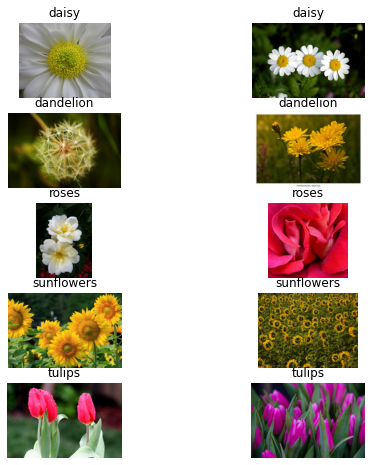

In [8]:
train_dataset = FlowerDataset(file_paths, labels, transform=ImageTransform(size, mean, std), phase='show')

# 이미지 시각화
figure = plt.figure(figsize=(8, 8))
cols, rows= 2, 5

for i in range(2*len(label_map)):
  img, label = train_dataset[i*250]
  img = img.swapaxes(0, 1) # 시각화를 위한 축 변경 / 또는 torchImg.permute(1, 2, 0)
  img = img.swapaxes(1, 2)
  figure.add_subplot(rows, cols, i+1)
  #plt.title(label_map[train_y[index].tolist()])
  plt.title(label_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap='gray')

plt.show()

**Train/Validation Split**

In [9]:
# train/validation set Split
file_paths, labels = np.array(file_paths), np.array(labels)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_idx, valid_idx in sss.split(file_paths, labels):
  #print("TRAIN:", train_idx, "VALIDATION:", valid_idx)
  X_train, X_valid = file_paths[train_idx], file_paths[valid_idx]
  y_train, y_valid = labels[train_idx], labels[valid_idx]

print(len(X_train), len(X_valid))
print(len(y_train), len(y_valid))

2000 500
2000 500


**Data Loader 정의**

In [115]:
# Dataset 정의
train_dataset = FlowerDataset(X_train, y_train, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = FlowerDataset(X_valid, y_valid, transform=ImageTransform(size, mean, std), phase='val')

# Data Loader 정의
train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_iterator = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train' : train_iterator, 'val' : valid_iterator}

batch_iterator = iter(train_iterator)
inputs, label = next(batch_iterator)

print(inputs.size())
print(label)


torch.Size([16, 3, 256, 256])
tensor([2, 1, 2, 4, 4, 2, 4, 4, 0, 1, 1, 3, 3, 0, 4, 1])


**Data Loader 테스트**

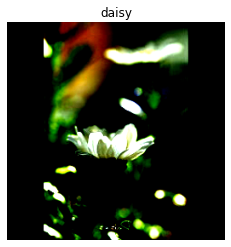

In [122]:
inputs, label = next(batch_iterator)
figure = plt.figure(figsize=(4, 4))
img = np.array(inputs[0])
img = img.swapaxes(0, 1) # 시각화를 위한 축 변경 / 또는 torchImg.permute(1, 2, 0)
img = img.swapaxes(1, 2)
plt.title(label_map[label[0].tolist()])
plt.axis("off")
plt.imshow(img.squeeze(), cmap='gray')
plt.show()

**Convolution Neural Network**

In [53]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

class ReLU(Function):
    @staticmethod
    def forward(ctx, input):
        output = input.clamp(min=0)
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input, None



class Net(nn.Module) :
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 12, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(12)
    self.conv2 = nn.Conv2d(12, 32, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(32)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128, 256, 5, 1, 1)
    self.bn5= nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256, 128, 3, 1, 1)
    self.bn6= nn.BatchNorm2d(128)
    self.conv7 = nn.Conv2d(128, 64, 3, 1, 1)
    self.bn7= nn.BatchNorm2d(64)
    self.conv8 = nn.Conv2d(64, 32, 3, 1, 1)
    self.bn8 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(32 * 31 * 31, 1200)  # 256 -> (256+0-3)/1 + 1 -> 254/2 -> 127+0-3 + 1 -> 125/2 = 61
    self.fc2 = nn.Linear(1200, 84)
    self.fc3 = nn.Linear(84, 5)
    self.relu = ReLU.apply

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.pool(x)
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.pool(x)
    x = self.relu(self.bn5(self.conv5(x)))
    x = self.relu(self.bn6(self.conv6(x)))
    x = self.pool(x)
    x = self.relu(self.bn7(self.conv7(x)))
    x = self.relu(self.bn8(self.conv8(x)))
    x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
    x = self.relu((self.fc1(x)))
    x = self.relu((self.fc2(x)))
    x = self.fc3(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

**Loss Function & Optimizer**

In [54]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.009)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
net = net.to(device)
criterion = criterion.to(device)

**신경망 학습**

In [55]:
for epoch in range(50):   # 데이터셋을 수차례 반복합니다.

  running_loss = 0.0
  for i, data in enumerate(train_iterator, 0):
    # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device) # 두 matrix 타입 맞추기

      # 변화도(Gradient) 매개변수를 0으로 만들고
      optimizer.zero_grad()

      # 순전파 + 역전파 + 최적화를 한 후
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # 통계를 출력합니다.
      running_loss += loss.item()
      if i % 20 == 19:    # print every 10 mini-batches
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
        running_loss = 0.0

print('Finished Training')

[1,    20] loss: 1.594
[1,    40] loss: 1.525
[1,    60] loss: 1.396
[1,    80] loss: 1.346
[1,   100] loss: 1.206
[1,   120] loss: 1.228
[2,    20] loss: 1.108
[2,    40] loss: 1.186
[2,    60] loss: 1.058
[2,    80] loss: 1.072
[2,   100] loss: 1.156
[2,   120] loss: 0.985
[3,    20] loss: 0.983
[3,    40] loss: 0.974
[3,    60] loss: 1.032
[3,    80] loss: 0.984
[3,   100] loss: 1.005
[3,   120] loss: 0.945
[4,    20] loss: 0.952
[4,    40] loss: 0.937
[4,    60] loss: 0.843
[4,    80] loss: 0.902
[4,   100] loss: 0.863
[4,   120] loss: 0.907
[5,    20] loss: 0.864
[5,    40] loss: 0.810
[5,    60] loss: 0.871
[5,    80] loss: 0.863
[5,   100] loss: 0.812
[5,   120] loss: 0.858
[6,    20] loss: 0.781
[6,    40] loss: 0.735
[6,    60] loss: 0.838
[6,    80] loss: 0.799
[6,   100] loss: 0.851
[6,   120] loss: 0.814
[7,    20] loss: 0.768
[7,    40] loss: 0.726
[7,    60] loss: 0.808
[7,    80] loss: 0.776
[7,   100] loss: 0.722
[7,   120] loss: 0.772
[8,    20] loss: 0.700
[8,    40] 

**Weight 저장**

In [156]:
torch.save(net.state_dict(), PATH+'/practice.pth')

In [185]:
valid_iter = iter(valid_iterator)

Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: torch.Size([16])


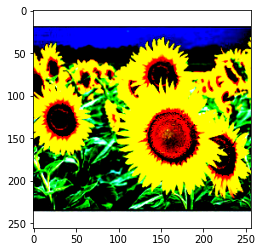

Label: sunflowers


In [189]:
# Valid DataLoader
valid_features, valid_labels = next(valid_iter)
print(f"Feature batch shape: {valid_features.size()}")
print(f"Labels batch shape: {valid_labels.size()}")
img = np.array(valid_features[0])
img = img.swapaxes(0, 1)
img = img.swapaxes(1, 2)
label = valid_labels.tolist()[0]
label = label_map[label]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

**Weight 불러오기**

In [174]:
net = Net()
net.load_state_dict(torch.load(PATH+'/practice.pth'))

<All keys matched successfully>

**Prediction 테스트**

In [190]:
outputs = net(valid_features)
_, predicted = torch.max(outputs, 1)
predicted = predicted.tolist()[0]

print('Predicted: ', ' '.join(f'{label_map[predicted]}'))

Predicted:  s u n f l o w e r s


**모델 평가**

In [182]:
valid_iter = iter(valid_iterator)
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in valid_iter:
        images, labels = data
        
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        #print(labels, " : ", predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(correct, total)
print(f'Accuracy of the network on the 500 test images: {100 * correct // total} %')

368 500
Accuracy of the network on the 500 test images: 73 %


In [183]:
valid_iter = iter(valid_iterator)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in label_map}
total_pred = {classname: 0 for classname in label_map}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
  for data in valid_iter:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # 각 분류별로 올바른 예측 수를 모읍니다
    for label, prediction in zip(labels, predictions):
      label = label.tolist()
      if label == prediction:
        correct_pred[label] += 1
      total_pred[label] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {label_map[classname]:5} is {accuracy:.1f} %')

Accuracy for class: daisy is 80.0 %
Accuracy for class: dandelion is 76.0 %
Accuracy for class: roses is 62.0 %
Accuracy for class: sunflowers is 79.0 %
Accuracy for class: tulips is 71.0 %


**Test Dataset**

In [191]:
PATH = "drive/MyDrive/집중교육2/data/test"
"""
with ZipFile(PATH+".zip", 'r') as zipObj:
    zipObj.extractall(PATH)
"""

'\nwith ZipFile(PATH+".zip", \'r\') as zipObj:\n    zipObj.extractall(PATH)\n'

In [101]:
root = PATH + '/test/'

test_file_paths = []

# 각 class 별로 500개의 train dataset
for dir in class_list :
  class_paths = sorted([os.path.join(root+dir, path) for path in os.listdir(root+dir)])
  test_file_paths.extend(class_paths)

test_labels = [path.split('/')[-2] for path in test_file_paths]
test_labels = [key for key in label_map.keys() for label in test_labels if label_map[key] == label]

print(test_labels)
print(len(test_file_paths))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

**Test Dataset으로 모델 평가**

In [150]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for test_path in test_file_paths:
        img = Image.open(test_path)
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='show')
        img = img.unsqueeze(0)
        label = test_path.split('/')[-2]
        for key in label_map.keys():
          if label_map[key] == label:
            label = key
        
        net.eval()
        outputs = net(img)
        
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.tolist()[0]
        #print(label, " : ", predicted)
        total += 1
        if predicted == label:
          correct += 1

print(f'Accuracy of the network on the 500 test images: {100 * correct // total} %')

Accuracy of the network on the 500 test images: 76 %


In [192]:
test_iteration = iter(test_file_paths)